In [20]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.util import shuffle_dataset
from common.optimizer import SGD, Adam
from common.trainer import Trainer

%matplotlib inline

# 6.1 パラメータの効率的な更新，最適化
- optimizerを実装して，重みパラメータと勾配を渡して更新する
- optimizerを変えるだけで，異なる最適化アルゴリズムを使える

***
### Momentum
$$
\boldsymbol{v} \leftarrow \alpha \boldsymbol{v} - \eta \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W + \boldsymbol{v}
$$

- $W$: 更新する重みパラメータ
- $\eta$: 学習率．インスタンス変数として
- $\boldsymbol{v}$: 速度にあたる変数．
- $\alpha$: 減速させる役割をもつ定数．(0.9などを使う)

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        # 初期化．速度の初期値はNone
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        # 初回更新時，vにparamsと同じ形状のデータをディクショナリとして持たせる
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        # paramsとvを更新する
        for key in params.keys():
            # 前回のvはmomentum分だけ減速，現在のparamsを元にした勾配で速度を更新
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            # 更新後の速度でparamsを更新
            params[key] += self.v[key]

***
### AdaGrad
$$
\boldsymbol{h} \leftarrow \boldsymbol{h} + \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W - \eta \frac{1}{\sqrt{\boldsymbol{h} + \epsilon}} \frac{\partial L}{\partial W}
$$

- $\otimes$ は要素ごとの積（アダマール積）を表す
- 学習率を減衰させる発想
- $\boldsymbol{h}$ は過去の勾配の2乗和を記憶していく
- 重みパラメータの更新の際には勾配を$\boldsymbol{h}$ で割ることで，徐々に更新の度合いを小さくする．平方根を取るのはスケールの調整．
- 無限に更新すると更新量が0になる．改良した手法としてRMSPropがある．

***
### RMSProp
$$
\boldsymbol{h} \leftarrow \beta \boldsymbol{h} + (1 - \beta) \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
W \leftarrow W - \eta \frac{1}{\sqrt{\boldsymbol{h} + \epsilon}} \frac{\partial L}{\partial W}
$$
- $\beta$ に0.9などの値を入れて，過去の勾配の影響を低下させ，新しい勾配の影響を大きくする


In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

***
### Adam
$$
\begin{align}
\boldsymbol{m}_t &\leftarrow \beta_1 \boldsymbol{m}_{t-1} + (1 - \beta_1) \frac{\partial L}{\partial W}
\\ \\
\boldsymbol{v}_t &\leftarrow \beta_2 \boldsymbol{v}_{t-1} + (1 - \beta_2) \frac{\partial L}{\partial W} \otimes \frac{\partial L}{\partial W}
\\ \\
\boldsymbol{\hat{m}}_t &\leftarrow \frac{\boldsymbol{m}_t}{(1 - \beta_1^t)}
\\ \\
\boldsymbol{\hat{v}}_t &\leftarrow \frac{\boldsymbol{v}_t}{(1 - \beta_2^t)}
\\ \\
W_t &\leftarrow W_{t-1} - \eta \frac{\boldsymbol{\hat{m}}_t}{\sqrt{\boldsymbol{\hat{v}}_t} + \epsilon}
\end{align}
$$

- [原著論文](https://paperswithcode.com/paper/adam-a-method-for-stochastic-optimization)
- MomentumとAdaGradの組み合わせ
- $\boldsymbol{m}$ はモーメント．勾配の移動平均．速度を保持．
- $\boldsymbol{v}$ は更新量．勾配の大きさの移動平均．過去のイテレーションで勾配が大きかったパラメータの更新量は小さく，勾配が小さかったパラメータの更新量は大きく調整．
- $\boldsymbol{m}, \ \boldsymbol{v}$ を $(1 - \beta^t)$ で割ることで，イテレーションの初期では大きく，イテレーションが進むほど小さくなるよう調整する．$\boldsymbol{m}_0, \ \boldsymbol{v}_0$ は0から始まるため，$t = 1$ のときなど，$\boldsymbol{m}, \ \boldsymbol{v}$ は非常に小さい値になってしまう．

***
### 最適化アルゴリズムの比較

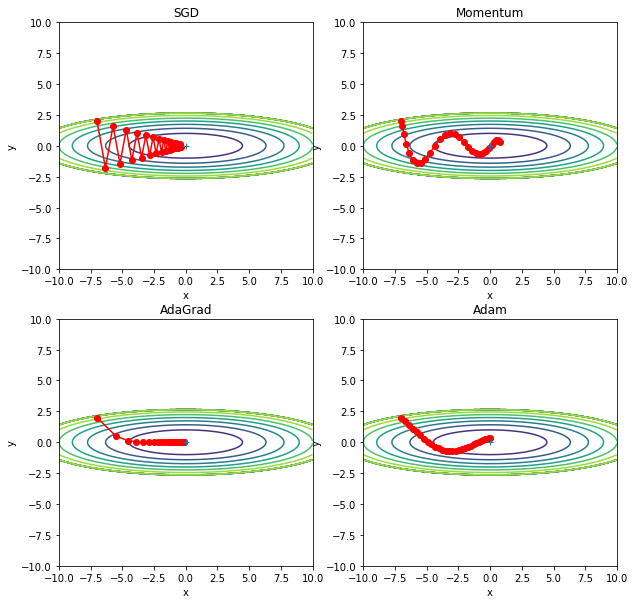

In [4]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

%matplotlib inline


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
plt.figure(figsize=(10, 10))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

# 6.2 重みの初期値
- 重みをなるべく小さくすることで，過学習が起きにくくなる（Weight decay = 荷重減衰）
- 初期値を均一な値にしてはいけない．全ての重みが均一に更新される

Affine変換 $\boldsymbol{x} W + \boldsymbol{b}= \boldsymbol{a}$ において，重みが均一な場合，次の層への出力，backpropの勾配が均一になる

中間層の全ノードへの入力が同じであるということは，複数のノードが存在する意味がなくなるということ

***
### 隠れ層のアクティベーション分布
##### 重みの初期値にガウス分布を用いて，その標準偏差を変えたときに隠れ層のアクティベーション関数の出力の分布がどう変化するかを観察
- 5層，各層は100個のニューロンを持つニューラルネットワークで実験

##### 活性化関数: Sigmoid
- 出力が0や1に偏りすぎると，勾配の値が小さくなり勾配消失に至る
- 出力が0.5付近であっても，同じ出力ばかりだとニューロンの多様性が失われ，表現力が制限される
- 前層ノード数を $n$ としたとき，$\sqrt{\frac{1}{n}}$ の標準偏差を持つ分布を使う:「Xavierの初期値」
- Xavierの初期値は活性化関数が線形であることを前提としたものだが，Sigmoidは中央付近が線形とみなせるため効果がある．

##### 活性化関数: ReLU
- ReLUに適したHeの初期値が使われる
- 前層ノード数を $n$ としたとき，$\sqrt{\frac{2}{n}}$ の標準偏差を持つ分布を使う
- 直観的な解釈: ReLUでは入力が負の場合は全て出力0になる＝多様性が低いため初期値のばらつきを大きくとる

***
#### 実験: アクティベーション関数の種類，初期値の正規分布の標準偏差を変えて出力の分布を確認する

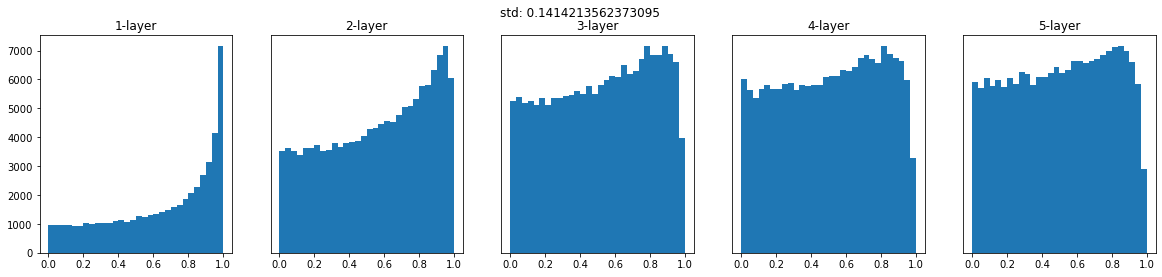

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
#     std = 1
#     std = 0.01
#     std = np.sqrt(1.0 / node_num) # Sigmoid 最適
    std = np.sqrt(2.0 / node_num) # ReLU 最適

    w = np.random.randn(node_num, node_num) * std

    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
#     z = sigmoid(a)
#     z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
plt.figure(figsize=(20, 4))
plt.suptitle('std: ' + str(std))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

***
# 6.3 Batch Normalization
$$
\begin{align}
\mu_{j} &\leftarrow \frac{1}{n} \Sigma_{i=1}^{n} x_{ij}
\\ \\
\sigma_{j}^2 &\leftarrow \frac{1}{n} \Sigma_{i=1}^{n} (x_{ij} - \mu_{j})^2
\\ \\
\hat{x}_{ij} &\leftarrow \frac{x_{ij} - \mu_{j}}{\sqrt{\sigma_{j}^2 + \epsilon}}
\\ \\
y_{ij} &\leftarrow \gamma_j \hat{x}_{ij} + \beta_j
\end{align}
$$
- アクティベーション関数の出力分布を調整する手法
- ミニバッチとして，サンプル数 $n$，次元 $m$ の以下の入力を考える（ノード数 $m$ である層からの出力）
$$
B = 
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1m} \\
x_{21} & x_{22} & \cdots & x_{2m} \\
\vdots & \vdots & & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{nm} \\
\end{pmatrix}
$$


- 入力データの各成分のミニバッチ全体の平均 $\mu_j$，分散 $\sigma_j$ を求める
- $\mu_j, \ \sigma_j$ を使って，データを標準化し，平均0，分散1にする（$\epsilon$ は0除算を防ぐため）
- 最後に固有のスケールとシフトで変換する．$\gamma, \ \beta$ はパラメータ．平均 $\beta$，分散 $\gamma$ になる？

***

#### 偏微分導出
- $\mu_{j} \leftarrow \frac{1}{n} \Sigma_{i=1}^{n} x_{ij}$ について
$$
\mu_{j} = \frac{1}{n} (x_{1j} + x_{2j} + \cdots + x_{nj})
$$
より
$$
\frac{\partial \mu_{j}}{\partial x_{ij}} = \frac{1}{n}
$$
<br><br>


- $\sigma_{j}^2 \leftarrow \frac{1}{n} \Sigma_{i=1}^{n} (x_{ij} - \mu_{j})^2$ について
$$
\begin{align}
    \frac{\partial \sigma_{j}^2}{\partial x_{ij}} 
        &= \frac{1}{n} \left\{
            \frac{\partial (x_{1j} - \mu_j)^2}{\partial x_{ij}} + \frac{\partial (x_{2j} - \mu_j)^2}{\partial x_{ij}} + \cdots + \frac{\partial (x_{nj} - \mu_j)^2}{\partial x_{ij}}
        \right\}
        \\
        &= \frac{1}{n} \Sigma_{\lambda=1}^{n} \frac{\partial (x_{\lambda j} - \mu_j)^2}{\partial x_{ij}}
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \frac{\partial (x_{\lambda j} - \mu_j)}{\partial x_{ij}}
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \left( \frac{\partial x_{\lambda j}}{\partial x_{ij}} - \frac{\partial \mu_j}{\partial x_{ij}} \right)
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j}) \left( \delta_{i \lambda} - \frac{1}{n} \right)
        \\
        &= \frac{2}{n} \Sigma_{\lambda=1}^{n} \delta_{i \lambda} (x_{\lambda j} - \mu_{j}) - \frac{2}{n^2} \Sigma_{\lambda=1}^{n} (x_{\lambda j} - \mu_{j})
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j}) - \frac{2}{n} \left( \frac{1}{n} \Sigma_{\lambda=1}^{n} x_{\lambda j} - \frac{1}{n} \Sigma_{\lambda=1}^{n} \mu_j \right)
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j}) - \frac{2}{n} (\mu_j - \mu_j)
        \\
        &= \frac{2}{n} (x_{ij} - \mu_{j})
\end{align}
$$
<br><br>



- $\hat{x}_{ij} \leftarrow \frac{x_{ij} - \mu_{j}}{\sqrt{\sigma_{j}^2 + \epsilon}}$ について

$s_j = \sqrt{\sigma_j^2 + \epsilon}$ とおけば 

$$
\begin{align}
    \frac{\partial s_j}{\partial x_{ij}}
        &= \frac{\partial s_j}{\partial \sigma_j^2} \frac{\partial \sigma_j^2}{\partial x_{ij}}
        \\
        &= \frac{1}{2 \sqrt{\sigma_j^2 + \epsilon}} \frac{2}{n} (x_{ij} - \mu_{j})
        \\
        &= \frac{x_{ij} - \mu_{j}}{n s_j}
    \\
    \\
    \frac{\partial \hat{x}_{kj}}{\partial x_{ij}}
        &= \frac{1}{s_j^2} \left\{
            s_j \frac{\partial (x_{kj} - \mu_{j})}{\partial x_{ij}} - \frac{\partial s_j}{\partial x_{ij}} (x_{kj} - \mu_{j})
        \right\}
        \\
        &= \frac{1}{s_j^2} \left\{
            s_j \left( \delta_{ik} - \frac{1}{n} \right) - \frac{x_{ij} - \mu_{j}}{n s_j} (x_{kj} - \mu_{j})
        \right\}
        \\
        &= \frac{1}{s_j} \left\{
            \delta_{ik} - \frac{1}{n} - \frac{(x_{ij} - \mu_{j})(x_{kj} - \mu_{j})}{n s_j^2}
        \right\}
        \\
        &= \frac{1}{s_j} \left(
            \delta_{ik} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{kj}}{n}
        \right)
\end{align}
$$
<br><br>


- $y_{ij} \leftarrow \gamma_j \hat{x}_{ij} + \beta_j$ について
$$
\begin{align}
    \frac{\partial y_{kj}}{\partial x_{ij}}
        &= \frac{\partial y_{kj}}{\partial \hat{x}_{kj}} \frac{\partial \hat{x}_{kj}}{\partial x_{ij}}
        \\
        &= \frac{\gamma_j}{s_j} \left(
            \delta_{ik} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{kj}}{n}
        \right)
    \\
    \\
    \frac{\partial y_{kj}}{\partial \beta_j} &= 1
    \\
    \\
    \frac{\partial y_{kj}}{\partial \gamma_j} &= \hat{x}_{kj}
\end{align}
$$
<br><br>


- 損失関数 $L$ の偏微分

第 $j$ ノードに対する損失は $y_{1j}, y_{2j}, \cdots, y_{nj}$ の関数

出力 $y_{ij}$ は $x_{1j}, x_{2j}, \cdots, x_{nj}$ の関数

$$
\begin{align}
    \frac{\partial L}{\partial x_{ij}}
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\partial y_{\lambda j}}{\partial x_{ij}}
        \\
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\gamma_j}{s_j} \left(
            \delta_{i \lambda} - \frac{1}{n} - \frac{\hat{x}_{ij} \hat{x}_{\lambda j}}{n}
        \right)
        \\
        &= \frac{\gamma_j}{s_j} \left\{
            \frac{\partial L}{\partial y_{ij}} - \frac{1}{n} \Sigma_{\lambda=1}^{n} (1 + \hat{x}_{ij} \hat{x}_{\lambda j}) \frac{\partial L}{\partial y_{\lambda j}}
        \right\}
\end{align}
$$

正規化パラメータ$\beta_j, \ \gamma_j$ について，

$$
\begin{align}
    \frac{\partial L}{\partial \beta_j}
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\partial y_{\lambda j}}{\partial \beta_j}
        \\
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}}
    \\
    \\
    \frac{\partial L}{\partial \gamma_j}
        &= \Sigma_{\lambda=1}^{n} \frac{\partial L}{\partial y_{\lambda j}} \frac{\partial y_{\lambda j}}{\partial \gamma_j}
        \\
        &= \Sigma_{\lambda=1}^{n} \hat{x}_{\lambda j} \frac{\partial L}{\partial y_{\lambda j}}
\end{align}
$$

よって

$$
\begin{align}
    \frac{\partial L}{\partial x_{ij}}
    &= \frac{\gamma_j}{s_j} \left\{
            \frac{\partial L}{\partial y_{ij}} - \frac{1}{n} \Sigma_{\lambda=1}^{n} (1 + \hat{x}_{ij} \hat{x}_{\lambda j}) \frac{\partial L}{\partial y_{\lambda j}}
        \right\}
    \\
    &= \frac{\gamma_j}{s_j} \left\{
            \frac{\partial L}{\partial y_{ij}} - \frac{1}{n} \left( \frac{\partial L}{\partial \beta_j} + \hat{x}_{ij} \frac{\partial L}{\partial \gamma_{j}} \right) \right\}
\end{align}
$$

***
#### Batch Normを使った実験

============== 1/16 ==============
epoch:0 | 0.099 - 0.121
epoch:1 | 0.097 - 0.103


/home/jovyan/work/deep-learning-from-scratch/ch06/../common/multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/jovyan/work/deep-learning-from-scratch/ch06/../common/multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:2 | 0.097 - 0.124
epoch:3 | 0.097 - 0.142
epoch:4 | 0.097 - 0.161
epoch:5 | 0.097 - 0.18
epoch:6 | 0.097 - 0.199
epoch:7 | 0.097 - 0.219
epoch:8 | 0.097 - 0.226
epoch:9 | 0.097 - 0.238
epoch:10 | 0.097 - 0.261
epoch:11 | 0.097 - 0.281
epoch:12 | 0.097 - 0.309
epoch:13 | 0.097 - 0.315
epoch:14 | 0.097 - 0.345
epoch:15 | 0.097 - 0.359
epoch:16 | 0.097 - 0.368
epoch:17 | 0.097 - 0.376
epoch:18 | 0.097 - 0.396


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.403
============== 2/16 ==============
epoch:0 | 0.116 - 0.104


/home/jovyan/work/deep-learning-from-scratch/ch06/../common/multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/home/jovyan/work/deep-learning-from-scratch/ch06/../common/multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.125
epoch:2 | 0.097 - 0.127
epoch:3 | 0.097 - 0.148
epoch:4 | 0.097 - 0.162
epoch:5 | 0.097 - 0.185
epoch:6 | 0.097 - 0.213
epoch:7 | 0.097 - 0.247
epoch:8 | 0.097 - 0.286
epoch:9 | 0.097 - 0.303
epoch:10 | 0.097 - 0.327
epoch:11 | 0.097 - 0.344
epoch:12 | 0.097 - 0.369
epoch:13 | 0.097 - 0.377
epoch:14 | 0.097 - 0.398
epoch:15 | 0.097 - 0.419
epoch:16 | 0.097 - 0.441
epoch:17 | 0.097 - 0.462


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.463
epoch:19 | 0.097 - 0.475
============== 3/16 ==============
epoch:0 | 0.091 - 0.117
epoch:1 | 0.218 - 0.163
epoch:2 | 0.298 - 0.19
epoch:3 | 0.376 - 0.227
epoch:4 | 0.457 - 0.296
epoch:5 | 0.538 - 0.326
epoch:6 | 0.596 - 0.344
epoch:7 | 0.622 - 0.372
epoch:8 | 0.683 - 0.405
epoch:9 | 0.723 - 0.423
epoch:10 | 0.744 - 0.45
epoch:11 | 0.752 - 0.486
epoch:12 | 0.794 - 0.509
epoch:13 | 0.809 - 0.525
epoch:14 | 0.834 - 0.549
epoch:15 | 0.841 - 0.567
epoch:16 | 0.861 - 0.58
epoch:17 | 0.874 - 0.604


No handles with labels found to put in legend.


epoch:18 | 0.883 - 0.619
epoch:19 | 0.887 - 0.638
============== 4/16 ==============
epoch:0 | 0.11 - 0.095
epoch:1 | 0.275 - 0.113
epoch:2 | 0.412 - 0.195
epoch:3 | 0.513 - 0.28
epoch:4 | 0.578 - 0.341
epoch:5 | 0.616 - 0.404
epoch:6 | 0.641 - 0.465
epoch:7 | 0.679 - 0.51
epoch:8 | 0.704 - 0.542
epoch:9 | 0.718 - 0.589
epoch:10 | 0.758 - 0.616
epoch:11 | 0.784 - 0.639
epoch:12 | 0.792 - 0.673
epoch:13 | 0.798 - 0.697
epoch:14 | 0.824 - 0.722
epoch:15 | 0.832 - 0.735
epoch:16 | 0.847 - 0.752
epoch:17 | 0.851 - 0.76
epoch:18 | 0.849 - 0.777
epoch:19 | 0.861 - 0.78


No handles with labels found to put in legend.


============== 5/16 ==============
epoch:0 | 0.113 - 0.102
epoch:1 | 0.124 - 0.155
epoch:2 | 0.125 - 0.287
epoch:3 | 0.129 - 0.405
epoch:4 | 0.128 - 0.494
epoch:5 | 0.143 - 0.549
epoch:6 | 0.148 - 0.605
epoch:7 | 0.152 - 0.649
epoch:8 | 0.155 - 0.697
epoch:9 | 0.162 - 0.726
epoch:10 | 0.161 - 0.745
epoch:11 | 0.164 - 0.768
epoch:12 | 0.167 - 0.801
epoch:13 | 0.167 - 0.801
epoch:14 | 0.169 - 0.816
epoch:15 | 0.173 - 0.834
epoch:16 | 0.178 - 0.843
epoch:17 | 0.185 - 0.859
epoch:18 | 0.191 - 0.868
epoch:19 | 0.197 - 0.875


No handles with labels found to put in legend.


============== 6/16 ==============
epoch:0 | 0.113 - 0.11
epoch:1 | 0.118 - 0.179
epoch:2 | 0.136 - 0.392
epoch:3 | 0.178 - 0.522
epoch:4 | 0.188 - 0.62
epoch:5 | 0.181 - 0.682
epoch:6 | 0.117 - 0.724
epoch:7 | 0.116 - 0.765
epoch:8 | 0.13 - 0.79
epoch:9 | 0.13 - 0.817
epoch:10 | 0.13 - 0.842
epoch:11 | 0.196 - 0.858
epoch:12 | 0.168 - 0.874
epoch:13 | 0.117 - 0.887
epoch:14 | 0.147 - 0.894
epoch:15 | 0.117 - 0.906
epoch:16 | 0.15 - 0.918
epoch:17 | 0.117 - 0.929
epoch:18 | 0.117 - 0.93


No handles with labels found to put in legend.


epoch:19 | 0.182 - 0.936
============== 7/16 ==============
epoch:0 | 0.117 - 0.111
epoch:1 | 0.116 - 0.364
epoch:2 | 0.116 - 0.608
epoch:3 | 0.117 - 0.724
epoch:4 | 0.117 - 0.765
epoch:5 | 0.117 - 0.801
epoch:6 | 0.116 - 0.837
epoch:7 | 0.116 - 0.868
epoch:8 | 0.116 - 0.899
epoch:9 | 0.116 - 0.916
epoch:10 | 0.116 - 0.939
epoch:11 | 0.116 - 0.958
epoch:12 | 0.116 - 0.966
epoch:13 | 0.117 - 0.972
epoch:14 | 0.117 - 0.983
epoch:15 | 0.117 - 0.987
epoch:16 | 0.117 - 0.989
epoch:17 | 0.117 - 0.993
epoch:18 | 0.117 - 0.993


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.994
============== 8/16 ==============
epoch:0 | 0.117 - 0.164
epoch:1 | 0.117 - 0.367
epoch:2 | 0.117 - 0.596
epoch:3 | 0.117 - 0.724
epoch:4 | 0.117 - 0.799
epoch:5 | 0.117 - 0.847
epoch:6 | 0.117 - 0.886
epoch:7 | 0.117 - 0.916
epoch:8 | 0.117 - 0.937
epoch:9 | 0.117 - 0.957
epoch:10 | 0.117 - 0.966
epoch:11 | 0.117 - 0.983
epoch:12 | 0.117 - 0.988
epoch:13 | 0.117 - 0.988
epoch:14 | 0.117 - 0.992
epoch:15 | 0.117 - 0.995
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.995
epoch:18 | 0.117 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.997
============== 9/16 ==============
epoch:0 | 0.117 - 0.122
epoch:1 | 0.116 - 0.568
epoch:2 | 0.117 - 0.644
epoch:3 | 0.116 - 0.756
epoch:4 | 0.117 - 0.818
epoch:5 | 0.116 - 0.871
epoch:6 | 0.117 - 0.89
epoch:7 | 0.117 - 0.899
epoch:8 | 0.117 - 0.918
epoch:9 | 0.117 - 0.971
epoch:10 | 0.117 - 0.98
epoch:11 | 0.117 - 0.992
epoch:12 | 0.117 - 0.995
epoch:13 | 0.117 - 0.995
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============== 10/16 ==============
epoch:0 | 0.116 - 0.138
epoch:1 | 0.116 - 0.534
epoch:2 | 0.116 - 0.652
epoch:3 | 0.116 - 0.662
epoch:4 | 0.117 - 0.669
epoch:5 | 0.116 - 0.693
epoch:6 | 0.116 - 0.744
epoch:7 | 0.117 - 0.762
epoch:8 | 0.117 - 0.777
epoch:9 | 0.117 - 0.794
epoch:10 | 0.117 - 0.797
epoch:11 | 0.117 - 0.797
epoch:12 | 0.117 - 0.806
epoch:13 | 0.117 - 0.807
epoch:14 | 0.117 - 0.817
epoch:15 | 0.117 - 0.843
epoch:16 | 0.117 - 0.897
epoch:17 | 0.117 - 0.904
epoch:18 | 0.117 - 0.905


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.905
============== 11/16 ==============
epoch:0 | 0.1 - 0.147
epoch:1 | 0.105 - 0.626
epoch:2 | 0.105 - 0.768
epoch:3 | 0.116 - 0.864
epoch:4 | 0.116 - 0.879
epoch:5 | 0.116 - 0.931
epoch:6 | 0.116 - 0.955
epoch:7 | 0.116 - 0.976
epoch:8 | 0.116 - 0.956
epoch:9 | 0.116 - 0.968
epoch:10 | 0.116 - 0.975
epoch:11 | 0.116 - 0.989
epoch:12 | 0.116 - 0.99
epoch:13 | 0.116 - 0.964
epoch:14 | 0.116 - 0.987
epoch:15 | 0.116 - 0.996
epoch:16 | 0.116 - 0.996
epoch:17 | 0.116 - 0.997
epoch:18 | 0.116 - 0.995
epoch:19 | 0.116 - 0.999


No handles with labels found to put in legend.


============== 12/16 ==============
epoch:0 | 0.099 - 0.138
epoch:1 | 0.099 - 0.556
epoch:2 | 0.116 - 0.757
epoch:3 | 0.117 - 0.775
epoch:4 | 0.116 - 0.815
epoch:5 | 0.116 - 0.695
epoch:6 | 0.116 - 0.85
epoch:7 | 0.117 - 0.841
epoch:8 | 0.117 - 0.872
epoch:9 | 0.116 - 0.884
epoch:10 | 0.116 - 0.887
epoch:11 | 0.116 - 0.888
epoch:12 | 0.116 - 0.791
epoch:13 | 0.116 - 0.887
epoch:14 | 0.116 - 0.887
epoch:15 | 0.116 - 0.885
epoch:16 | 0.116 - 0.89
epoch:17 | 0.116 - 0.89
epoch:18 | 0.116 - 0.891
epoch:19 | 0.117 - 0.896


No handles with labels found to put in legend.


============== 13/16 ==============
epoch:0 | 0.105 - 0.17
epoch:1 | 0.116 - 0.471
epoch:2 | 0.116 - 0.543
epoch:3 | 0.116 - 0.611
epoch:4 | 0.116 - 0.612
epoch:5 | 0.116 - 0.659
epoch:6 | 0.116 - 0.504
epoch:7 | 0.116 - 0.67
epoch:8 | 0.116 - 0.687
epoch:9 | 0.116 - 0.686
epoch:10 | 0.116 - 0.673
epoch:11 | 0.117 - 0.693
epoch:12 | 0.117 - 0.7
epoch:13 | 0.117 - 0.699
epoch:14 | 0.117 - 0.708
epoch:15 | 0.117 - 0.703
epoch:16 | 0.117 - 0.706
epoch:17 | 0.117 - 0.794
epoch:18 | 0.117 - 0.809


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.808
============== 14/16 ==============
epoch:0 | 0.116 - 0.171
epoch:1 | 0.117 - 0.384
epoch:2 | 0.116 - 0.466
epoch:3 | 0.116 - 0.558
epoch:4 | 0.116 - 0.569
epoch:5 | 0.116 - 0.554
epoch:6 | 0.116 - 0.575
epoch:7 | 0.116 - 0.593
epoch:8 | 0.116 - 0.591
epoch:9 | 0.116 - 0.608
epoch:10 | 0.116 - 0.302
epoch:11 | 0.116 - 0.603
epoch:12 | 0.116 - 0.597
epoch:13 | 0.116 - 0.609
epoch:14 | 0.116 - 0.612
epoch:15 | 0.116 - 0.615
epoch:16 | 0.116 - 0.678
epoch:17 | 0.116 - 0.632
epoch:18 | 0.116 - 0.708


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.706
============== 15/16 ==============
epoch:0 | 0.117 - 0.161
epoch:1 | 0.117 - 0.334
epoch:2 | 0.117 - 0.415
epoch:3 | 0.117 - 0.457
epoch:4 | 0.117 - 0.478
epoch:5 | 0.117 - 0.485
epoch:6 | 0.117 - 0.495
epoch:7 | 0.117 - 0.503
epoch:8 | 0.117 - 0.498
epoch:9 | 0.117 - 0.503
epoch:10 | 0.117 - 0.509
epoch:11 | 0.117 - 0.51
epoch:12 | 0.117 - 0.514
epoch:13 | 0.117 - 0.513
epoch:14 | 0.117 - 0.513
epoch:15 | 0.117 - 0.516
epoch:16 | 0.117 - 0.514
epoch:17 | 0.117 - 0.515
epoch:18 | 0.117 - 0.515


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.516
============== 16/16 ==============
epoch:0 | 0.116 - 0.148
epoch:1 | 0.116 - 0.323
epoch:2 | 0.116 - 0.411
epoch:3 | 0.116 - 0.409
epoch:4 | 0.117 - 0.422
epoch:5 | 0.116 - 0.421
epoch:6 | 0.116 - 0.423
epoch:7 | 0.116 - 0.5
epoch:8 | 0.116 - 0.429
epoch:9 | 0.116 - 0.431
epoch:10 | 0.116 - 0.516
epoch:11 | 0.116 - 0.51
epoch:12 | 0.116 - 0.521
epoch:13 | 0.116 - 0.503
epoch:14 | 0.116 - 0.525
epoch:15 | 0.116 - 0.508
epoch:16 | 0.117 - 0.511
epoch:17 | 0.117 - 0.525
epoch:18 | 0.117 - 0.525
epoch:19 | 0.117 - 0.53


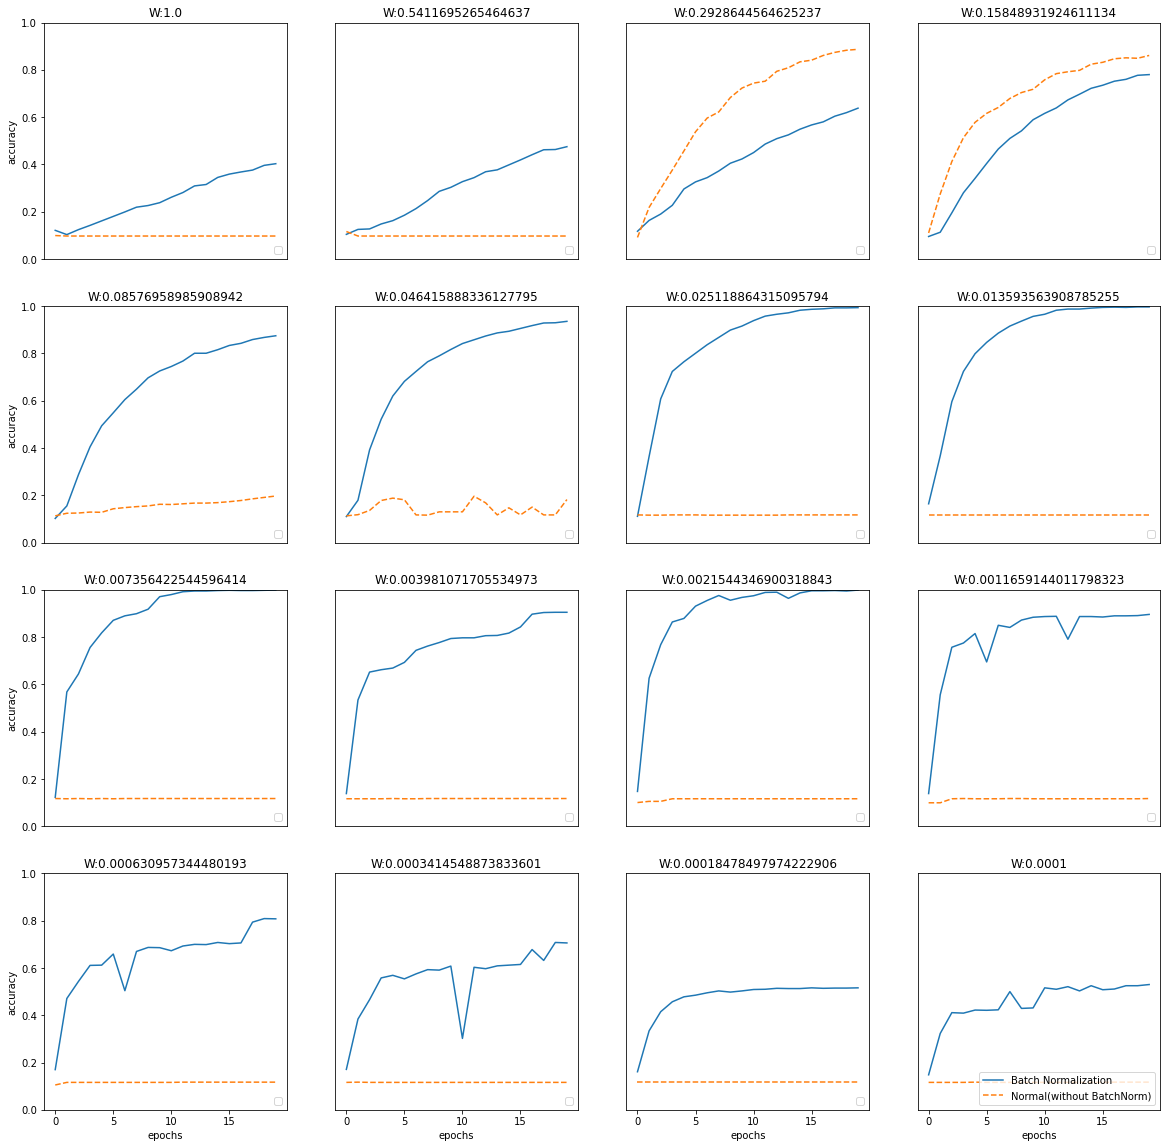

In [6]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

plt.figure(figsize=(20, 20))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

# 6.4 正則化

### 過学習の状態を確認
- train setに対する精度が非常に高い一方，test setに対する精度が低い
- train setにだけ，過剰に最適化されている状態＝汎化性能が低い


### Weight decay
- 作戦: 「重みパラメータが大きい値を取りにくくする」
- 損失関数に重みパラメータのL2ノルムを足す（L1ノルム，Maxノルムなど様々ある）

損失関数を $L(X)$（2乗和誤差や交差エントロピー誤差），パラメータを $W$，Weight decayの強さを制御するハイパーパラメータを $C$ とすれば，以下のように損失を計算する
$$
Loss = L(X) + \frac{1}{2} C W^2
$$

epoch:0, train acc:0.10666666666666667, test acc:0.0825
epoch:1, train acc:0.12, test acc:0.0901
epoch:2, train acc:0.12666666666666668, test acc:0.0971
epoch:3, train acc:0.13333333333333333, test acc:0.1065
epoch:4, train acc:0.17, test acc:0.1164
epoch:5, train acc:0.18333333333333332, test acc:0.1298
epoch:6, train acc:0.21, test acc:0.1463
epoch:7, train acc:0.22, test acc:0.166
epoch:8, train acc:0.26, test acc:0.1893
epoch:9, train acc:0.2866666666666667, test acc:0.2072
epoch:10, train acc:0.30333333333333334, test acc:0.2282
epoch:11, train acc:0.32, test acc:0.2425
epoch:12, train acc:0.31666666666666665, test acc:0.2468
epoch:13, train acc:0.3433333333333333, test acc:0.2662
epoch:14, train acc:0.37666666666666665, test acc:0.2828
epoch:15, train acc:0.39, test acc:0.2836
epoch:16, train acc:0.39666666666666667, test acc:0.2909
epoch:17, train acc:0.41, test acc:0.3132
epoch:18, train acc:0.43, test acc:0.3285
epoch:19, train acc:0.44, test acc:0.3348
epoch:20, train acc:0.4

epoch:162, train acc:0.8866666666666667, test acc:0.7262
epoch:163, train acc:0.88, test acc:0.7275
epoch:164, train acc:0.8966666666666666, test acc:0.7354
epoch:165, train acc:0.9, test acc:0.7336
epoch:166, train acc:0.8866666666666667, test acc:0.7296
epoch:167, train acc:0.9033333333333333, test acc:0.7326
epoch:168, train acc:0.89, test acc:0.7329
epoch:169, train acc:0.91, test acc:0.7388
epoch:170, train acc:0.8933333333333333, test acc:0.7349
epoch:171, train acc:0.9, test acc:0.7394
epoch:172, train acc:0.9, test acc:0.7349
epoch:173, train acc:0.8966666666666666, test acc:0.7332
epoch:174, train acc:0.9033333333333333, test acc:0.7346
epoch:175, train acc:0.9133333333333333, test acc:0.7374
epoch:176, train acc:0.9033333333333333, test acc:0.7341
epoch:177, train acc:0.8966666666666666, test acc:0.7333
epoch:178, train acc:0.9033333333333333, test acc:0.7333
epoch:179, train acc:0.9, test acc:0.7268
epoch:180, train acc:0.9133333333333333, test acc:0.7334
epoch:181, train ac

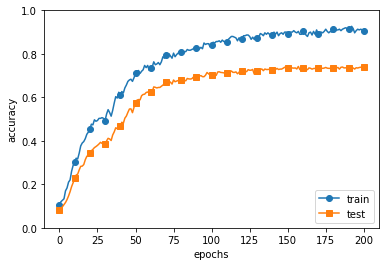

In [7]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
# weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### Dropout
- 作戦: 「ニューロンを減らして，ネットワークが複雑になりすぎないようにする」
- 隠れ層のニューロンをランダムに消去して学習
- テスト時は全てのニューロンを使うが，学習時に消去した割合を乗算して出力する
- 実質的にはアンサンブル学習を行っているようなもの

わかりやすさ重視の実装例

In [8]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        # 学習ではself.maskに消去するニューロンを保持する
        # テストではdropout_ratioを乗算
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio # *(tuple)でアンパック
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        # maskを使って消去したニューロンは逆伝播を止める
        return dout * self.mask

train loss:2.342232599547391
=== epoch:1, train acc:0.11333333333333333, test acc:0.0902 ===
train loss:2.3298534033754343
train loss:2.3104307571452507
train loss:2.311350438790684
=== epoch:2, train acc:0.11666666666666667, test acc:0.0947 ===
train loss:2.321562385935234
train loss:2.3150726820921914
train loss:2.2995115739897094
=== epoch:3, train acc:0.11666666666666667, test acc:0.0977 ===
train loss:2.2947113058753175
train loss:2.3182932247543557
train loss:2.305497732117619
=== epoch:4, train acc:0.11666666666666667, test acc:0.0976 ===
train loss:2.3341903867980527
train loss:2.305759417378307
train loss:2.3192811297723774
=== epoch:5, train acc:0.12, test acc:0.098 ===
train loss:2.304364865099394
train loss:2.326461062717608
train loss:2.3128175063512084
=== epoch:6, train acc:0.12, test acc:0.097 ===
train loss:2.3129023429382305
train loss:2.3148459264615617
train loss:2.2998617321751995
=== epoch:7, train acc:0.12, test acc:0.1008 ===
train loss:2.314779865164181
train l

=== epoch:57, train acc:0.25333333333333335, test acc:0.198 ===
train loss:2.2521116148067803
train loss:2.2654199666281998
train loss:2.267969381823047
=== epoch:58, train acc:0.25, test acc:0.2039 ===
train loss:2.2553305035920075
train loss:2.2524263093360073
train loss:2.2541510382316905
=== epoch:59, train acc:0.25666666666666665, test acc:0.2041 ===
train loss:2.250258364377101
train loss:2.2548874689082985
train loss:2.2556166695150233
=== epoch:60, train acc:0.25666666666666665, test acc:0.2023 ===
train loss:2.2525282504364412
train loss:2.235350039777077
train loss:2.243496364484716
=== epoch:61, train acc:0.25333333333333335, test acc:0.2014 ===
train loss:2.251058270887604
train loss:2.2423826506952027
train loss:2.2295255095383766
=== epoch:62, train acc:0.25, test acc:0.2008 ===
train loss:2.258534207464106
train loss:2.2583287798304297
train loss:2.251472029602771
=== epoch:63, train acc:0.26666666666666666, test acc:0.2038 ===
train loss:2.257515810420902
train loss:2.2

=== epoch:113, train acc:0.31666666666666665, test acc:0.2451 ===
train loss:2.1822720838019065
train loss:2.160874488463822
train loss:2.1468034971143957
=== epoch:114, train acc:0.3233333333333333, test acc:0.2473 ===
train loss:2.1768803030416173
train loss:2.1642358672180246
train loss:2.157647289609704
=== epoch:115, train acc:0.32666666666666666, test acc:0.2475 ===
train loss:2.1760627794359086
train loss:2.1867835450808797
train loss:2.192100970536675
=== epoch:116, train acc:0.34, test acc:0.2547 ===
train loss:2.149279055210748
train loss:2.124440229697856
train loss:2.1602506286435936
=== epoch:117, train acc:0.33, test acc:0.2518 ===
train loss:2.1850171053368306
train loss:2.142875062122386
train loss:2.1609678150775924
=== epoch:118, train acc:0.3333333333333333, test acc:0.2528 ===
train loss:2.1511329880749623
train loss:2.1590059104629047
train loss:2.163398080112621
=== epoch:119, train acc:0.34, test acc:0.2543 ===
train loss:2.171103141430485
train loss:2.1337900825

=== epoch:168, train acc:0.46, test acc:0.3394 ===
train loss:2.0113142066704506
train loss:2.0508645794039624
train loss:2.002033517194257
=== epoch:169, train acc:0.46, test acc:0.3414 ===
train loss:2.010827366153974
train loss:1.9869953162860015
train loss:1.991168842504906
=== epoch:170, train acc:0.46, test acc:0.3447 ===
train loss:2.0204086855867076
train loss:1.8815280412074233
train loss:2.0348366842101915
=== epoch:171, train acc:0.46, test acc:0.3416 ===
train loss:1.926902266834433
train loss:1.9754585167456091
train loss:2.060895502749267
=== epoch:172, train acc:0.45666666666666667, test acc:0.3446 ===
train loss:2.0496194112468227
train loss:1.9162591290008077
train loss:1.9361115543725669
=== epoch:173, train acc:0.45666666666666667, test acc:0.3456 ===
train loss:2.009381972036074
train loss:2.0264052640462697
train loss:1.9235186571861198
=== epoch:174, train acc:0.45, test acc:0.3429 ===
train loss:2.0069812542283443
train loss:2.0613426021669827
train loss:1.977911

=== epoch:224, train acc:0.5133333333333333, test acc:0.4028 ===
train loss:1.7253590255176439
train loss:1.7794423249532358
train loss:1.7901596495029621
=== epoch:225, train acc:0.5133333333333333, test acc:0.4042 ===
train loss:1.8246734769198267
train loss:1.707395087032637
train loss:1.8190115331077248
=== epoch:226, train acc:0.5133333333333333, test acc:0.4048 ===
train loss:1.7313993192189654
train loss:1.7099277405112687
train loss:1.6854336290449796
=== epoch:227, train acc:0.5133333333333333, test acc:0.4062 ===
train loss:1.8663957154736368
train loss:1.8664520416999577
train loss:1.7651053002708428
=== epoch:228, train acc:0.5133333333333333, test acc:0.4093 ===
train loss:1.66141350011532
train loss:1.6830651886586292
train loss:1.7939555630091666
=== epoch:229, train acc:0.5133333333333333, test acc:0.4106 ===
train loss:1.6813494683301804
train loss:1.6607736318550146
train loss:1.6893268194949338
=== epoch:230, train acc:0.5133333333333333, test acc:0.4107 ===
train lo

=== epoch:279, train acc:0.5633333333333334, test acc:0.4577 ===
train loss:1.4112134746632368
train loss:1.3733615950743683
train loss:1.4617007948000171
=== epoch:280, train acc:0.5633333333333334, test acc:0.4577 ===
train loss:1.4610447526159636
train loss:1.520564051274088
train loss:1.3680938644849094
=== epoch:281, train acc:0.5666666666666667, test acc:0.4579 ===
train loss:1.4513259319845444
train loss:1.2650179444858283
train loss:1.5371745092975462
=== epoch:282, train acc:0.5633333333333334, test acc:0.4597 ===
train loss:1.3685754924795503
train loss:1.440290965558365
train loss:1.4798364914408895
=== epoch:283, train acc:0.5666666666666667, test acc:0.4602 ===
train loss:1.4578011802673247
train loss:1.5375836062153254
train loss:1.5420897210862945
=== epoch:284, train acc:0.5766666666666667, test acc:0.4636 ===
train loss:1.5035151167228868
train loss:1.362325178651037
train loss:1.5702196823812418
=== epoch:285, train acc:0.58, test acc:0.465 ===
train loss:1.3486741657

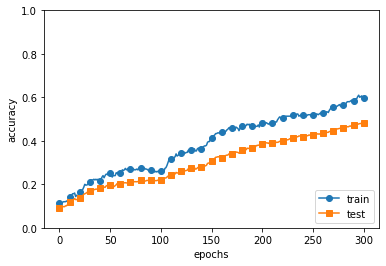

In [9]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### ハイパーパラメータの最適化
- validation setを使って調整する
- 対数スケールの大まかな探索 => 筋の良い範囲を絞り込み
- 効率的に行うならベイズ最適化を勉強せよ！
- 対数スケールでのランダムサンプリングの例. np.random.uniform(low, high) でlowからhighの連続一様分布

In [18]:
10 ** np.random.uniform(-3, 3)

13.180508026209449

- learning rate と Weight decay 係数の最適値探索

val acc:0.17 | lr:0.0010237301741589503, weight decay:1.924427284777589e-06
val acc:0.16 | lr:0.0005731849762164379, weight decay:4.9606716905729563e-05
val acc:0.72 | lr:0.005345082609062335, weight decay:1.70083130985292e-05
val acc:0.39 | lr:0.0013186639016238596, weight decay:3.898309099173733e-06
val acc:0.08 | lr:3.087556320502153e-05, weight decay:9.23416333066776e-06
val acc:0.08 | lr:4.674354147597084e-05, weight decay:3.253689453062104e-08
val acc:0.15 | lr:2.169117891207456e-06, weight decay:2.9976048761661276e-08
val acc:0.06 | lr:3.468333916060858e-06, weight decay:1.7104067228795794e-05
val acc:0.17 | lr:1.9623898574091313e-06, weight decay:8.779311918018837e-08
val acc:0.28 | lr:0.002227561443788615, weight decay:8.321186278217026e-06
val acc:0.07 | lr:1.087608044783876e-06, weight decay:1.3088744888672109e-05
val acc:0.11 | lr:1.9183680360841232e-05, weight decay:1.0778779737207776e-08
val acc:0.07 | lr:4.6024610294506516e-06, weight decay:8.458765809830878e-05
val acc:

Best-13(val acc:0.49) | lr:0.0033692866290054996, weight decay:3.955377969137823e-08
Best-14(val acc:0.49) | lr:0.0024175723348068444, weight decay:7.790626507104704e-07
Best-15(val acc:0.48) | lr:0.0029131702821673816, weight decay:1.1541919741794986e-06
Best-16(val acc:0.48) | lr:0.002454997187946265, weight decay:1.2922639261650631e-06
Best-17(val acc:0.42) | lr:0.001761342433361615, weight decay:2.631767150620704e-06
Best-18(val acc:0.39) | lr:0.0013186639016238596, weight decay:3.898309099173733e-06
Best-19(val acc:0.39) | lr:0.0018209767876144465, weight decay:2.318479044380938e-08
Best-20(val acc:0.38) | lr:0.0016931210028143264, weight decay:1.5033027341359626e-06


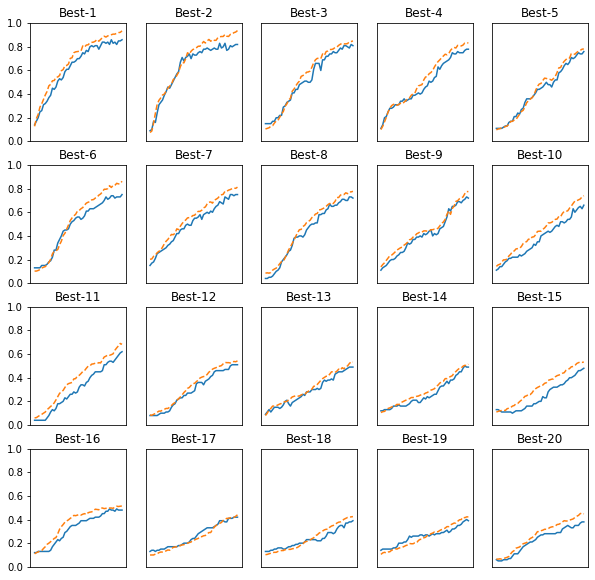

In [21]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(10, 10))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()